## Display the logs

This notebook intend to facilitate the access to the log files content. Once you've run the model set log id to the targeted one to access the content of ```./data/logs/log_id```.

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

from src.utils.aligners import AbundancesAligner
from src.utils.metrics import SRE, SADDegrees, aRMSE, eRMSE
from src.utils.metrics import compute_metric

In [ ]:
log_id = 1

### Utils 

In [9]:
def extract_data_ground_truth(dataset_name):
    path_to_data = f"./data/{dataset_name}.mat"
    Y = loadmat(path_to_data)
    E = loadmat(path_to_data)["E"]
    A = loadmat(path_to_data)["A"]
    return Y, E, A

In [6]:
def extract_data_from_lod(log_id):
    path_to_log = f"./logs/{log_id}/artifacts/Estimate/estimates.mat"
    E_hat = loadmat(path_to_log)["E"]
    A_hat = loadmat(path_to_log)["A"]
    return E_hat, A_hat

In [10]:
def get_metrics(A_gt, A_hat, E_gt, E_hat, n_ems=3):

    # align the abundance matrix 
    aligner = AbundancesAligner(Aref=A_gt)
    A1 = aligner.fit_transform(A_hat)
    E1 = aligner.transform_endmembers(E_hat)

    labels = [f"#{ii}" for ii in range(n_ems)]

    # compute metrics
    sre = compute_metric(SRE(),
                         A_gt,
                         A1,
                         labels,
                         detail=False,
                         on_endmembers=False,
                         )

    saddeg = compute_metric(
                                aRMSE(),
                                A_gt,
                                A1,
                                labels,
                                detail=True,
                                on_endmembers=False,
                            )

    armse = compute_metric(
                            SADDegrees(),
                            E_gt,
                            E1,
                            labels,
                            detail=True,
                            on_endmembers=True,
                        )

    rmse = compute_metric(
                            eRMSE(),
                            E_gt,
                            E1,
                            labels,
                            detail=True,
                            on_endmembers=True,
                        )
    return sre, saddeg, armse, rmse

### Prepare data and compute metrics

In [33]:
# log real dataset
dataset_name  = "adapted_for_hysupp_Samson"
Y, E_gt, A_gt = extract_data_ground_truth(dataset_name)

# log predictions of specified log_id
log_id = 1
E_hat, A_hat = extract_data_from_lod(log_id)

# align data 
aligner = AbundancesAligner(Aref=A_gt)
A1 = aligner.fit_transform(A_hat.reshape(A_gt.shape))
E1 = aligner.transform_endmembers(E_hat)

# compute metrics
sre, saddeg, armse, rmse = get_metrics(A_gt, A1, E_gt, E1)

print(f"SRE = {sre}")
print(f"SAD Degrees = {saddeg}")
print(f"ARMSE = {armse}")
print(f"eRMSE = {rmse}")

SRE = {'Overall': 14.8875}
SAD Degrees = {'Overall': 9.04, '#0': 10.4569, '#1': 9.8641, '#2': 6.2064}
ARMSE = {'Overall': 2.1556, '#0': 0.7688, '#1': 2.3878, '#2': 3.31}
eRMSE = {'Overall': 13.9747, '#0': 10.8716, '#1': 21.1882, '#2': 4.3298}


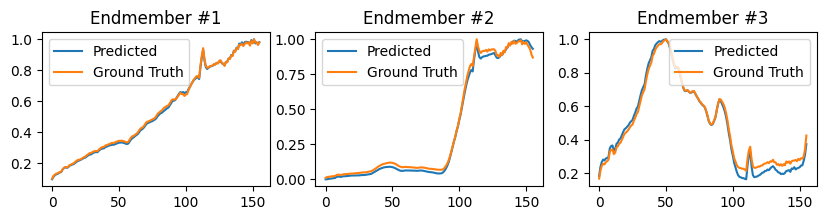

In [34]:
fig, axs = plt.subplots(1, E1.shape[1], figsize=(10,2))
for i in range(E1.shape[1]):
    axs[i].plot(E1[:, i] / E1[:, i].max())
    axs[i].plot(E_gt[:, i])
    axs[i].legend(["Predicted", "Ground Truth"])
    axs[i].set_title(f"Endmember #{i+1}")
plt.show()